<div class="alert alert-success">
Note: if this notebook is taking too long to run, consider using the module HierarchicalClustering v7.3.4 available on gp-beta-ami.genepattern.org

This notebook can be used to find genes which are differentially expressed in two phenotypes. 

A note on some of the parameters we are using:

- **gene expression**: We use a compilation of 40 RNASeq samples taken from TCGA, 20 of those are Breast Cancer primary tumors (BRCA) and 20 are matched normal tissue. Here is the GCT file which contains those HTSeq counts:  
https://raw.githubusercontent.com/genepattern/differential-expression-modalities/master/data/workshop_BRCA_filtered.gct  

- **phenotype file**: We will use this CLS file to identify the samples' phenotype   
https://raw.githubusercontent.com/genepattern/differential-expression-modalities/master/data/workshop_BRCA_labels.cls

In [1]:
import genepattern
import cuzcatlan as cusca
import pandas as pd

def hc_samples(input_gene_expression, clustering_type, distance_metric):
    print("Currenty clustering_type is being ignored, only single is supported.")
    pwd = '.'
    gct_name = input_gene_expression
    col_distance_metric = distance_metric
    output_distances = False
    row_distance_metric = 'No_row_clustering'
    clustering_method = 'average'
    output_base_name = 'OC_HC'
    row_normalization = False
    col_normalization = False
    row_centering = 'Mean'
    col_centering = 'Mean'
    
    print("This are the parameters to be used (for debugging purposes)")
    print("""
    pwd = '.'
    gct_name = {gct_name}
    col_distance_metric = {col_distance_metric}
    output_distances = {output_distances}
    row_distance_metric = {row_distance_metric}
    clustering_method = {clustering_method}
    output_base_name = {output_base_name}
    row_normalization = {row_normalization}
    col_normalization = {col_normalization}
    row_centering = {row_centering}
    col_centering = {col_centering}
    """.format(
        gct_name=gct_name, col_distance_metric=col_distance_metric, 
        output_distances=str(output_distances),
        row_distance_metric=row_distance_metric, clustering_method=clustering_method,
        output_base_name=output_base_name, 
        row_normalization=str(row_normalization), col_normalization=str(col_normalization), 
        row_centering=row_centering, col_centering=col_centering
    )
         )
    print("Now we will start performing hierarchical clustering, this may take a little while.")
    col_model, row_model = cusca.HierarchicalClustering(pwd,
                                                         gct_name,
                                                         col_distance_metric,
                                                         output_distances,
                                                         row_distance_metric,
                                                         clustering_method,
                                                         output_base_name,
                                                         row_normalization,
                                                         col_normalization,
                                                         row_centering,
                                                         col_centering)
    print("Done with Hierarchical Clustering!")
    print("Now we are crafting the dendrogram...")
    print(col_model)
    
    return col_model
    

genepattern.GPUIBuilder(hc_samples, name="Hierarchical Clustering of Samples (Columns).", 
                        description="This function performs hierarchical clustering to group samples (columns) with similar phenotypes..",
                        parameters={
                                "distance_metric":{
                                                      "default": "pearson",
                                                      "choices":{'Pearson Correlation Matching':"pearson",
                                                                 'Information Correlation Matching':"information_coefficient",
                                                                }
                                                     }
                        })

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


GPUIBuilder(description='This function performs hierarchical clustering to group samples (columns) with similar phenotypes..', function_import='hc_samples', name='Hierarchical Clustering of Samples (Columns).', params=[{'name': 'input_gene_expression', 'label': 'input_gene_expression', 'optional': False, 'default': '', 'description': '', 'hide': False, 'type': 'text', 'kinds': None, 'choices': []}, {'name': 'clustering_type', 'label': 'clustering_type', 'optional': False, 'default': '', 'description': '', 'hide': False, 'type': 'text', 'kinds': None, 'choices': []}, {'name': 'distance_metric', 'label': 'distance_metric', 'optional': False, 'default': 'pearson', 'description': '', 'hide': False, 'type': 'text', 'kinds': None, 'choices': {'Pearson Correlation Matching': 'pearson', 'Information Correlation Matching': 'information_coefficient'}}])

In [155]:
col_model = hc_samples(input_gene_expression="Data/test_BRCA_minimal_60x19.gct", clustering_type="single", distance_metric="pearson")

Currenty clustering_type is being ignored, only single is supported.
This are the parameters to be used (for debugging purposes)

    pwd = '.'
    gct_name = Data/test_BRCA_minimal_60x19.gct
    col_distance_metric = pearson
    output_distances = False
    row_distance_metric = No_row_clustering
    clustering_method = average
    output_base_name = OC_HC
    row_normalization = False
    col_normalization = False
    row_centering = Mean
    col_centering = Mean
    
Now we will start performing hierarchical clustering, this may take a little while.
Done with Hierarchical Clustering!
Now we are crafting the dendrogram...
AgglomerativeClustering(affinity=<function my_affinity_p at 0x7f0cc37832f0>,
            compute_full_tree='auto', connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=2,
            pooling_func=<function mean at 0x7f0cfc0ddd08>)


In [156]:
def make_tree(model):
    return dict(enumerate(model.children_, model.n_leaves_))

In [193]:
def plot_dendrogram(model, data, tree, axis, dist=cusca.mydist, title='no_title.png', col_thresh=0, **kwargs):
#     plt.clf()

    #modified from https://github.com/scikit-learn/scikit-learn/pull/3464/files
    # Children of hierarchical clustering
    children = model.children_
    # Distances between each pair of children
    #TODO: Fix this mydist
    # distance = dendodist(children, euclidian_similarity)
    # distance = dendodist(children, dist)

    og_distances = better_dendodist(children, dist, tree, data, axis=axis)
#     print(og_distances)
#     og_distances = [abs(temp) for temp in og_distances]
#     og_distances = [abs(temp) for temp in og_distances]
#     print(og_distances)
    distance = np.cumsum(og_distances)
#     distance = og_distances
#     distance = better_dendodist(children, dist, tree, data, axis=axis)

    # norm_distances = []
    # for value in distance:
    #     norm_distances.append(1/value)
    # norm_distances = distance

    list_of_children = list(get_children(tree, leaves_are_self_children=False).values())
    no_of_observations = [len(i) for i in list_of_children if i]
    no_of_observations.append(len(no_of_observations)+1)
    # print(len(no_of_observations))

    # print(children)

    # print(list(tree.values()))

    # print(norm_distances)

    # print(distance)
    if all(value == 0 for value in distance):
        # If all distances are zero, then use uniform distance
        distance = np.arange(len(distance))

    # print(distance)
    # print(np.cumsum(distance))

    # The number of observations contained in each cluster level
    # no_of_observations = np.arange(2, children.shape[0]+2)
    # print(no_of_observations)


    # Create linkage matrix and then plot the dendrogram
    # linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    # linkage_matrix = np.column_stack([children, np.cumsum(distance), no_of_observations]).astype(float)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    # linkage_matrix = np.column_stack([children, norm_distances, no_of_observations]).astype(float)
    # print(linkage_matrix)
    # Plot the corresponding dendrogram
    
#     print(linkage_matrix)


    R = dendrogram(linkage_matrix, color_threshold=col_thresh, **kwargs)
#     R = dendrogram(linkage_matrix, **kwargs)
#     [label.set_rotation(90) for label in plt.gca().get_xticklabels()]
    order_of_columns = R['ivl']
    # # print(order_of_columns)
#     plt.gca().get_yaxis().set_visible(False)
#     plt.savefig(title, dpi=300)
#     plt.show()

    # n = len(linkage_matrix) + 1
    # cache = dict()
    # for k in range(len(linkage_matrix)):
    #     c1, c2 = int(linkage_matrix[k][0]), int(linkage_matrix[k][1])
    #     c1 = [c1] if c1 < n else cache.pop(c1)
    #     c2 = [c2] if c2 < n else cache.pop(c2)
    #     cache[n + k] = c1 + c2
    # order_of_columns = cache[2 * len(linkage_matrix)]
    return order_of_columns, linkage_matrix


def better_dendodist(children, distance, tree, data, axis):
    distances_list = []
    for pair in children:
        distances_list.append(centroid_distances(pair[0], pair[1], tree, data, axis, distance=distance))
#         print(distance, pair, distances_list[-1])
    return distances_list


def centroid_distances(node_a, node_b, tree, data, axis=0, distance=cusca.mydist, clustering_method='average'):
    if axis == 0:
        pass
    elif axis == 1:
        data = np.transpose(data)
    else:
        exit("Variable 'data' does not have that many axises (╯°□°)╯︵ ┻━┻")

    children_of_a = list_children_single_node(node_a, tree=tree, leaves_are_self_children=True)
    children_of_b = list_children_single_node(node_b, tree=tree, leaves_are_self_children=True)

    # if distance == custom_euclidean_sim:
    #     print("Euclidean distance is especial, normalizing using this scheme:")
    #     distance = custom_euclidean_dist

    distances_list = []
    if clustering_method == 'average':
        for pair in itertools.product(data[children_of_a], data[children_of_b]):
            distances_list.append(distance(pair[0], pair[1]))
        return np.average(distances_list)
    elif clustering_method == 'complete':
        for pair in itertools.product(data[children_of_a], data[children_of_b]):
            distances_list.append(distance(pair[0], pair[1]))
        return np.min(distances_list)
    else:
        exit("Ony 'average' and 'complete' clustering methods are accepted at the moment (>_<)")
        
        
def list_children_single_node(node, tree, leaves_are_self_children=False, only_leaves_are_children=True):
    # children = []
    if node <= len(tree):
        if leaves_are_self_children:
            children = [node]
        else:
            children = []

    else:
        children = list(tree[node])

        # Check each child, and add their children to the list
        for child in children:
            if child <= len(tree):
                pass
            else:
                children += list_children_single_node(child, tree, only_leaves_are_children=True)
    if only_leaves_are_children:
        # print(sorted(np.unique(i for i in children if i <= len(tree))))
        # print()
        return [i for i in sorted(np.unique(children))if i <= len(tree)]
    else:
        return sorted(np.unique(children))
    
def get_children(tree, leaves_are_self_children=False):
    # this is a recursive function
    expanded_tree = {}
    for node in range(max(tree.keys())):
        if node <= len(tree):
            if leaves_are_self_children:
                expanded_tree[node] = [node]
            else:
                expanded_tree[node] = []

        else:
            # expanded_tree[node] = list_children_single_node(node, tree)
            expanded_tree[node] = list_children_single_node(node, tree, leaves_are_self_children)

    return expanded_tree

axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
axis is 1
1
[9, 0, 7, 8, 3, 6, 4, 5, 1, 2, 11, 12, 14, 13, 15, 16, 18, 10, 17]


/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/__main__.py:27: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


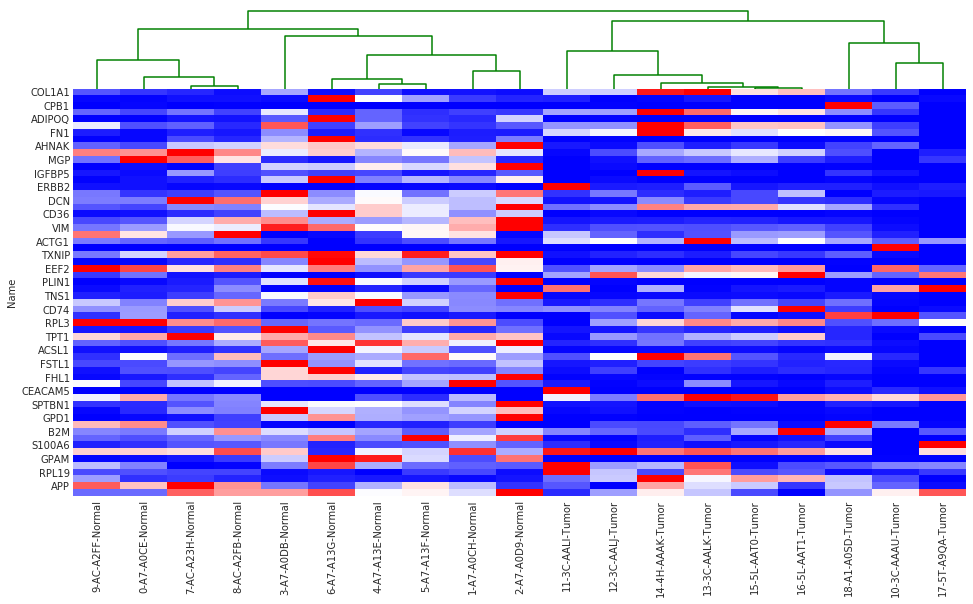

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.cluster.hierarchy import dendrogram
from matplotlib import gridspec
import seaborn as sns

# Plotting the heatmap with dendrogram

plt.clf()
# fig = plt.figure(figsize=(16, 9), dpi=300) 
fig = plt.figure(figsize=(16, 9)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5])
gs.update(wspace=0.0, hspace=0.0)
ax0 = plt.subplot(gs[0])  # Doing dendrogram first
ax0.axis('off')
data = pd.read_table("Data/test_BRCA_minimal_60x19.gct", skiprows=2)
data.set_index('Name', inplace=True)
data.drop('Description', axis=1, inplace=True)
# print(data)
# data = data.as_matrix()
col_order, link = plot_dendrogram(col_model, data.as_matrix(), make_tree(col_model), axis=1, dist=cusca.custom_pearson_dist, col_thresh=15, title='no_title.png')
col_order = [int(i) for i in col_order]

print(col_order)
data = data.reindex_axis(data.columns[col_order], axis=1)

#row-normalizing data
data = data.subtract(data.min(axis=1), axis=0)
data = data.div(data.max(axis=1), axis=0)

ax1 = plt.subplot(gs[1])
sns.heatmap(data, ax=ax1, cbar=False, cmap='bwr')
# ax1.xaxis.tick_top()
[label.set_rotation(90) for label in ax1.get_xticklabels()]
# plt.tight_layout()
plt.show()

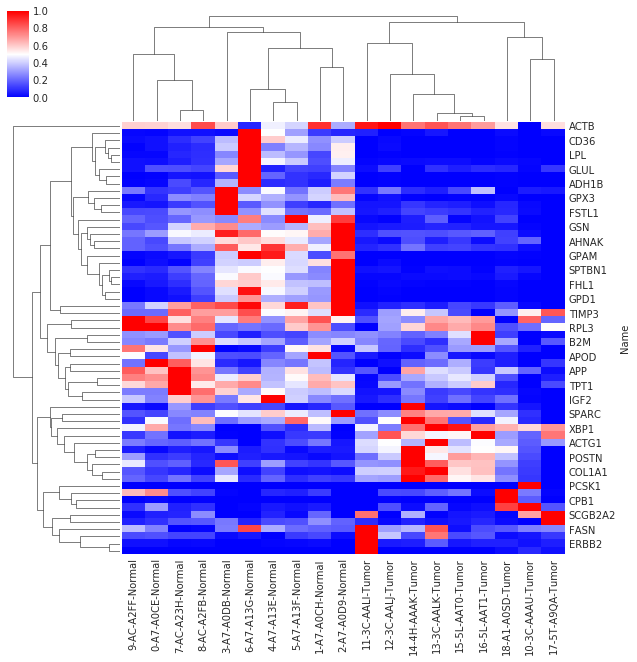

In [160]:
plt.clf()
data = pd.read_table("Data/test_BRCA_minimal_60x19.gct", skiprows=2)
data.set_index('Name', inplace=True)
data.drop('Description', axis=1, inplace=True)
data = data.subtract(data.min(axis=1), axis=0)
data = data.div(data.max(axis=1), axis=0)
sns.clustermap(data, col_linkage=link, cmap='bwr')
plt.show()